<a href="https://colab.research.google.com/github/walker-at/Replicating-the-An-Image-is-Worth-16x16-Words-Paper/blob/main/PyTorch_Paper_Replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating the Vision Transformer Architecture from "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale."

Paper: https://arxiv.org/abs/2010.11929

#### Overview of Transformers and Their Application To This Here Computer Vision Problem:

As a self-attention based architecture, Transformers are the model of choice for Large Language Models (LLM). In an LLM they work by splitting a text of words into pieces called tokens, these tokens are then made to attend to one another (via scaled dot product) with the goal of learning the weights of their connection on the fly.

In application to a Computer Vision (CV) problem, our tokens will instead be attained by splitting an image into patches then flattening them. In order to classify the image after it passes through the transformer, a learnable class token not associated with any of the patches will be prepended to the pathcified and flattened image. Finally, each individual patch will receive a corresponding position embedding; this sequence of linear embeddings with a class token prepended will then be provided as the input to the Transformer.

We will use the ViT-Base Model as outlined in Table 1

#### CNN vs Transformers
Each layer has 2 sublayers - multihead self-attention mechanism and fully-connnected feed-forward network

In distinction from Convolutional Neural Networks (CNN), Transformers "lack inductive bias like translation equivariance and locality."
* Translation Equivariance - ability to take note of transformations on an input image, i.e., recognize objects regardless of their orientation.
* Locality - information exchange within a local region, for CV such locality pertains to lines, edges, and shapes within an image.

CNNs can account for local connectivity because they bind the receptivity to a filter, which is panned around the entire image according to certain size and stride, allowing the filter to find and match patterns no matter where the pattern is located in a given image.

In short, Transformers must be fed a large enough data size to trump their lack of bias / generalizing ability.


For a recent paper on Equivariance in Transformers w.r.t. CV:

* https://arxiv.org/abs/2006.10503 SE(3)-Transformers: 3D Roto-Translation Equivariant Attention Networks

For a recent paper introducing depth-wise convolution for Locality in Vision Transformers:

* https://arxiv.org/abs/2104.05707 LocalViT: Bringing Locality to Vision Transformers

For a recent paper on overcoming Vision Transformers' poor performance on small datasets with Locality:

* https://arxiv.org/abs/2207.10026 Locality Guidance for Improving Vision Transformers on Tiny Datasets

### ViT Architecture

![ViT Architecture](https://drive.google.com/uc?export=view&id=1HLExUNAAzT-QVg4DkEZCFMxPwxCuyyIa)

### Table 1: We Will Use ViT-Base Hyperparameters

![Table 1](https://drive.google.com/uc?export=view&id=12Hp-0Pw1nuGFec8LAlmqgtd2AQQhIRJr)

### Equations 1-4

![Equations 1-4](https://drive.google.com/uc?export=view&id=1pNbG7kyMCFEKPyKuRt8jX8kCK73ETYWq)

### Table 1 Hyperparameters
  * Hidden size D - embedding dimension aka vector size our image gets turned into once patched and embedded. This is the learnable (numerical) representation of our input images.
  * MLP size - # of hidden units in the multilayer peceptron (MLP)
  * Heads - # of multi-head self-attention


### Input/Output Shapes and Other Variables

* Input image: H * W * C
* Output image: N * (P^2 * C)

* H = height
* W = width
* C = color channels
* P = patch size
* N = num of patches = (H * W) / P^2 = 16x16 specified in Model Variants section of ViT paper
* D = vector size aka embedding dimension

## 1. Import Libraries and Set Device

In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import requests
import shutil
import os
from pathlib import Path

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [2]:
# Download modules from GitHub
!git clone https://github.com/walker-at/Replicating-the-An-Image-is-Worth-16x16-Words-Paper
!mv Replicating-the-An-Image-is-Worth-16x16-Words-Paper/modules .
!rm -rf Replicating-the-An-Image-is-Worth-16x16-Words-Paper
from modules import data_setup, training_funcs, helper_funcs, pred_image

Cloning into 'Replicating-the-An-Image-is-Worth-16x16-Words-Paper'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 155 (delta 56), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (155/155), 14.57 MiB | 5.92 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [3]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 2. Get Data
I have downloaded the 300 total images for the classes apple_pie, baby_back_ribs, and bread_pudding from the Food101 dataset. This has been sorted into train and test folders and uploaded to github.

In [4]:
# Download apple_pie, baby_back_ribs, bread_pudding images from GitHub
image_path = helper_funcs.get_data(source="https://github.com/walker-at/Replicating-the-An-Image-is-Worth-16x16-Words-Paper/raw/main/three_foods_10_percent.zip",
                           destination="three_foods")
image_path

data/three_foods does not exist, creating it
downloading three_foods_10_percent.zip from https://github.com/walker-at/Replicating-the-An-Image-is-Worth-16x16-Words-Paper/raw/main/three_foods_10_percent.zip
unzipping three_foods_10_percent.zip


PosixPath('data/three_foods')

In [5]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

### 2.1 Create Datasets and Dataloader for ViT-Base (see Table 1 in the ViT paper)

* Training resolution in the ViT paper is 224 (Table 3).
* We need to reformat our data to match the image size (H, W) used in the ViT architecture (224, 224)

* The batch size used in the ViT paper is 4096 (Table 3). It took 8 TPUv3 cores 30 days to complete training for the ViT paper, for the sake of my macbook pro, we will reduce the batch size to 32

In [6]:
# from modules import data_setup
# from torchvision import transforms

IMG_SIZE = 224
BATCH_SIZE = 32

# transforms pipeline
manual_transforms = transforms.Compose([
                                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor()
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['apple_pie', 'baby_back_ribs', 'bread_pudding'])

### 2.2 Visualize a Sample Image
* Get a batch of images by turning the train_dataloader into a python iterator then get the next sample therefrom.

* Matplotlib likes color channels last, so we permute our image.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


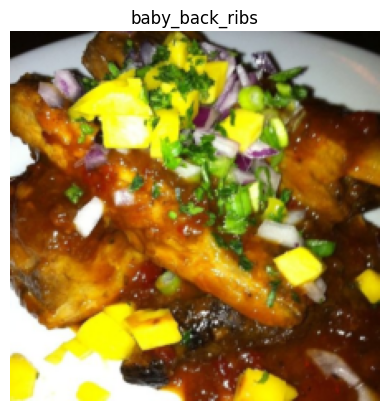

In [7]:
# get the batch
image_batch, label_batch = next(iter(train_dataloader))

# get the first image and label from the batch
image, label = image_batch[0], label_batch[0]

# view
image.shape, label

# plot
plt.imshow(image.permute(1, 2, 0)) # color channels, height, width --> height, width, color channels
plt.title(class_names[label])
plt.axis(False);

## 3. Equation 1: Split Data into Patches and Create the Class, Position and Patch Embedding

Breakdown:
* Eq1_output = [class_token, patch1_embedding, patch2_embedding, ... patchN_embedding] + [position_token for each of the elements in that previous vector]
* D (768) is the embedding size that we will project our patches too


Our steps
* input image -> patchify image -> learnable patch embedding (vector) -> prepend learnable classification token to the patch embeddings -> add position embedding for each patch embedding



### 3.1 Calculate Input/Output Shape, to be Re-Created later by PyTorch Layers

* see section 3.1 of ViT paper for input/output shapes of the patch embedding layer

In [8]:
height = 224 # H (The training resolution)
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P (Table 5)

# Calculate N
number_of_patches = int((height * width) / patch_size**2)
print(f"{number_of_patches} number of patches with an image height, width, and patch size of ({height}, {width}, {patch_size})")

196 number of patches with an image height, width, and patch size of (224, 224, 16)


In [9]:
# input shape
embedding_layer_input_shape = (height, width, color_channels)

# Calculate the output shape (number of patches, embedding dimension D)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (2D image): {embedding_layer_input_shape}")
print(f"Output shape (1D sequence of an image flattened into patches ): {embedding_layer_output_shape}")

Input shape (2D image): (224, 224, 3)
Output shape (1D sequence of an image flattened into patches ): (196, 768)


### 3.2 Turning a single image into patches and visualizing it

number of patches per row & column: 14.0
total patches: 196.0
patch size: 16 pixels x 16 pixels


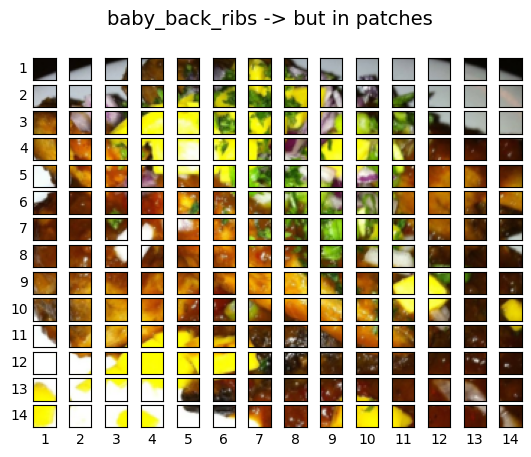

In [10]:
# convert image to have color channels last
image_permuted = image.permute(1, 2, 0)

# setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0 # double check image size is divisible by the patch size
print(f'number of patches per row & column: {num_patches}\
\ntotal patches: {num_patches*num_patches}\
\npatch size: {patch_size} pixels x {patch_size} pixels')

# create series of subplots to iterate through the patches, plotting them individually
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        sharex=True, # we want all pathces to share the same x and y axis
                        sharey=True)

# loop through height and width of image, iterating from 0 to the total image size with a step of each individual patch size
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # plot the permuted image on different axes
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                    patch_width:patch_width+patch_size,
                                    :]) # all color channels
    axs[i, j].set_ylabel(i+1,
                         rotation='horizontal',
                         horizontalalignment='right',
                         verticalalignment='center')
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer() # labels on outside

# title for the plot
fig.suptitle(f'{class_names[label]} -> but in patches', fontsize=14)
plt.show()

### 3.3 Image to Patches and Patch Embeddings in a Single Step Using torch.nn.Conv2d()
* Described under the Hybrid Architecture section of paper: "...the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension."

In [11]:
# nn.Conv2d() layer to turn an image into patches of learnable feature maps (embeddings)
# from torch import nn
conv2d = nn.Conv2d(in_channels=3, # color channels
                   out_channels=768, # D, embedding size
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [12]:
# Pass the image through our conv2d layer. Notice how we will still have 2D format.
img_after_conv = conv2d(image.unsqueeze(0)) # add a batch dimension to get the format as (batch, embedding_dim, height, width)
print(img_after_conv.shape)

torch.Size([1, 768, 14, 14])


random convolutional feature maps from indexes: [179, 240, 678, 197, 327]


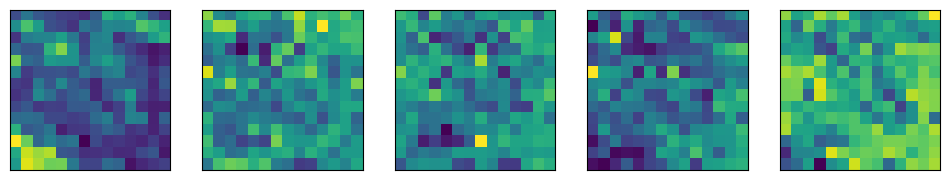

In [13]:
# Visualize 5 random convolutional feature maps (our learnable embedding)
# import random
random_indexes = random.sample(range(0, 758), k=5)
print(f'random convolutional feature maps from indexes: {random_indexes}')

# create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# plot random image feature maps
for i, idx in enumerate(random_indexes):
  img_conv_map = img_after_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  axs[i].imshow(img_conv_map.squeeze().detach().numpy()) # remove batch dim, and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### 3.4 Flattening the Patch Embeddings into a Sequence with torch.nn.flatten()
* Current tensor shape is still in 2D format: [batch_size, embedding_dim, height, width].
* In order to match the correct input shape of the ViT transformer encoder we need: [batch_size, num_patches, embedding_dim].

In [14]:
# height and width are at position 2 and 3
flatten = nn.Flatten(start_dim=2,
                     end_dim=3)

# flatten and permute
flattened_img = flatten(img_after_conv)
patch_embedded_img = flattened_img.permute(0, 2, 1)

In [15]:
# Print shape from: Input Image ->  Patch Embeddings -> Flattened Patch Embeddings -> Flattened & Permuted Patch Embeddings
print(f'Original image shape: {image.shape}')
print(f'Image feature map shape: {img_after_conv.shape}')
print(f'Flattened feature map shape: {flattened_img.shape}')
print(f'Flattened & permuted feature map shape: {patch_embedded_img.shape} -> (batch_size, num_patches, embedding_dimension')

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened feature map shape: torch.Size([1, 768, 196])
Flattened & permuted feature map shape: torch.Size([1, 196, 768]) -> (batch_size, num_patches, embedding_dimension


(-0.5, 195.5, 0.5, -0.5)

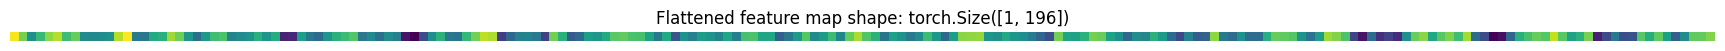

In [16]:
# Visualize flattened feature map for our image
flattened_feature_map = patch_embedded_img[:, :, 0]

# plot
plt.figure(figsize=(22, 22))
plt.imshow(flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {flattened_feature_map.shape}')
plt.axis(False)

### 3.5 Creating the Class Embedding Token

In [17]:
# get the batch size and embedding dimension
batch_size = patch_embedded_img.shape[0]
embedding_dimension = patch_embedded_img.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [18]:
# Create the class token embedding as a learnable parameter with the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [19]:
# prepend class token embedding to the patch embedding
patch_embedded_img_with_class_embedding = torch.cat((class_token, patch_embedded_img),
                                                      dim=1) # number_of_patches dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_img_with_class_embedding)
print(f"Sequence of patch embeddings with class token shape: {patch_embedded_img_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.5521,  0.3826,  1.5201,  ..., -1.2853, -0.4859,  1.4079],
         [-0.0398, -0.1470,  0.1194,  ..., -0.1873, -0.1000,  0.0331],
         [-0.2266, -0.0435,  0.2127,  ..., -0.2674, -0.4195,  0.2964],
         ...,
         [-0.2608, -0.1644,  0.1696,  ..., -0.2019, -0.0217,  0.0169],
         [-0.2570, -0.3524,  0.1088,  ..., -0.2414, -0.0912,  0.0785],
         [-0.2062, -0.1182,  0.1905,  ..., -0.3160, -0.0619, -0.0137]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 3.6  Creating the Position Embedding (by Hand)

We want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [20]:
# view the sequence of patch embeddings with the prepended class embedding
patch_embedded_img_with_class_embedding

tensor([[[-0.5521,  0.3826,  1.5201,  ..., -1.2853, -0.4859,  1.4079],
         [-0.0398, -0.1470,  0.1194,  ..., -0.1873, -0.1000,  0.0331],
         [-0.2266, -0.0435,  0.2127,  ..., -0.2674, -0.4195,  0.2964],
         ...,
         [-0.2608, -0.1644,  0.1696,  ..., -0.2019, -0.0217,  0.0169],
         [-0.2570, -0.3524,  0.1088,  ..., -0.2414, -0.0912,  0.0785],
         [-0.2062, -0.1182,  0.1905,  ..., -0.3160, -0.0619, -0.0137]]],
       grad_fn=<CatBackward0>)

In [21]:
# calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# get the emebdding dimension
embedding_dimension = patch_embedded_img_with_class_embedding.shape[-1]

# create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.randn(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[-0.0864,  1.7001,  0.8018,  ..., -0.1996, -1.3428,  0.4191],
          [ 0.4534, -0.3669,  0.7456,  ..., -0.7016, -1.0783,  0.1475],
          [-1.1889,  0.0523, -0.2130,  ..., -1.0432,  1.2283,  1.5511],
          ...,
          [-0.4867, -1.4563,  0.1652,  ...,  0.1448, -1.4376,  0.1694],
          [ 1.2590, -1.0797, -0.6318,  ...,  1.2171,  0.0718, -0.6134],
          [ 1.0294, -0.7297,  0.4108,  ...,  0.6615, -0.0337, -0.4793]]],
        requires_grad=True),
 torch.Size([1, 197, 768]))

In [22]:
# add the position embeddding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_img_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f'patch and position embedding shape: {patch_and_position_embedding.shape}')

tensor([[[-6.3850e-01,  2.0828e+00,  2.3219e+00,  ..., -1.4850e+00,
          -1.8287e+00,  1.8269e+00],
         [ 4.1356e-01, -5.1396e-01,  8.6501e-01,  ..., -8.8884e-01,
          -1.1783e+00,  1.8063e-01],
         [-1.4155e+00,  8.7639e-03, -2.9264e-04,  ..., -1.3105e+00,
           8.0878e-01,  1.8475e+00],
         ...,
         [-7.4752e-01, -1.6206e+00,  3.3474e-01,  ..., -5.7094e-02,
          -1.4593e+00,  1.8629e-01],
         [ 1.0019e+00, -1.4321e+00, -5.2296e-01,  ...,  9.7576e-01,
          -1.9422e-02, -5.3493e-01],
         [ 8.2314e-01, -8.4784e-01,  6.0132e-01,  ...,  3.4551e-01,
          -9.5631e-02, -4.9309e-01]]], grad_fn=<AddBackward0>)
patch and position embedding shape: torch.Size([1, 197, 768])


### 3.7 Create the ViT Patch Embedding Layer (Equation 1) as a PyTorch Module.

We will turn the previous steps into reusable code.

* Our class will inherit from nn.Module
* Hyperparameters: color channels, embedding dim, patch size
* Layer to turn an image into patches using nn.Conv2d() (from 3.3 above).
* Layer to flatten the patch feature maps into a single dimension (from 3.4 above).
* Layer to prepend the learnable class token (section 3.5 above)
* Layer to add the position embedding (section 3.6 above)
* Define a forward() function to pass an input through the nn.Conv2d() and flatten layers.

In [23]:
class PatchEmbedding(nn.Module):
  '''
  Takes a 2D input image and converts it into a 1D learnable embedding vector.

  Args:
      in_channels (int): Num of color channels
      patch_size (int): Size of patch to convert image to
      embedding_dim (int): Size of embedding to convert image into.
  '''
  def __init__(self,
               img_size:int=224, # training res from table 3
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # from table 1 for ViT
    super().__init__()

    self.patch_size = patch_size

    self.num_patches = (img_size * img_size) // patch_size**2

    # layer to turn an image into embedded patches
    self.patchify = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # layer to flatten feature map outputs of Conv2d
    self.flatten = nn.Flatten(start_dim=2, # only flatten height and width of feature map
                              end_dim=3)

    # learnable class embedding
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                           requires_grad=True)

  # func for the forward computation steps
  def forward(self, x):

    # batch size
    batch_size = x.shape[0]

    # class token - expand the single learnable class token across the batch dimension
    class_token = self.class_embedding.expand(batch_size, -1, -1) # we need to infer the dimension

    # patch_embedding
    x = self.patchify(x)

    # flatten
    x = self.flatten(x)

    # reshape
    x = x.permute(0, 2, 1)

    # prepend class embedding
    x = torch.cat((class_token, x), dim=1)

    # position embedding
    x = self.position_embedding + x

    return x

In [24]:
#instantiate patch embedding layer
helper_funcs.set_seeds()

patch_embedding = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# pass a single image through the patch embedding layer
print(f'Input image shape: {image.unsqueeze(0).shape}')
patch_embedded_img = patch_embedding(image.unsqueeze(0)) # add an extra batch dimension
print(f'Output patch embedding sequence shape: {patch_embedded_img.shape}')

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 197, 768])


### 3.8 Check the Shape Changes throughout the First Layer of our Architecture (Equation 1) -> Going from Image to Embedding
In this layer we go from a 2D image to 1D learnable embedding vector (a sequence of flattened 2D patches) (see section 3.1 of ViT paper).

Steps:

1. Setting the seed
2. Setting the patch size (16 is used throughout the paper for ViT-Base).
3. Getting a single image, printing its shape and storing its height and width.
4. Adding a batch dimension to the single image so it's compatible with our PatchEmbedding layer.
5. Creating a PatchEmbedding layer with a patch_size=16 and embedding_dim=768 (from Table 1 for ViT-Base).
6. Passing the single image through the PatchEmbedding layer to create a sequence of patch embeddings


In [25]:
# 1.
helper_funcs.set_seeds()

# 2.
patch_size = 16

# 3. shape of the original image tensor and store the height and width
print(f'image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

# 4. get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f'input image shape: {x.shape}')

# 5. patch embedding layer
patch_embedding = PatchEmbedding(in_channels=3,
                                 patch_size=patch_size,
                                 embedding_dim=768)

# 6. pass input image through patch embedding
patch_embedded_img = patch_embedding(x)
print(f'Shape after patch embedding: {patch_embedded_img.shape}')

image tensor shape: torch.Size([3, 224, 224])
input image shape: torch.Size([1, 3, 224, 224])
Shape after patch embedding: torch.Size([1, 197, 768])


## 4. Equation 2: Multi-Head Self-Attention (MSA) Block Consisting of MSA layer and LayerNorm (LN)

Breakdown:
* Eq_2 output = MSA_layer(LN_layers(Eq1_output)) + Eq1_output

Notes:
* We'll add skip/residual connection later on. This means the input, in our case embedded patches, gets added to the output of the block.
* By adding the input to the output we are preventing the gradients from being too small, making it easier to optimize and allowing for a deeper network.


### Parable on The Layernorm Layer

Imagine trying to climb a ladder where each peg is a different size and spaced out unevenly -- What we learn from each peg wouldn't help with navigating the next one, slowing down our climbing speed.

Normalization is like making all the pegs of a ladder the same size and distance, except the pegs are our data samples. This makes it easier for the Neural Network to optimize over.

By getting the data into similar mean and standard deviations we are improving training time and model generealization on unseen data.

torch.nn.LayerNorm()'s main parameter is normalized_shape (in our case the dimension size we want to normalize over is 768).

### MSA Layer

* Self-attention calculates on the fly which patch is most related to another patch, we don't specify patterns to learn.
* MSA layer takes a triple input of query, key, value.


### 4.1 Turn Equation 2 into a PyTorch Module for the ViT MSA Block (Part 1 of our Transformer Encoder)

In [26]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # from table 1
               num_heads:int=12, # from table 1
               attn_dropout:int=0): # appendix B specifies dropout not used after qkv projections
    super().__init__()

    # LN is going to normalize our input values across the shape we choose
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # MSA layer
    self.mh_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                        num_heads=num_heads,
                                        dropout=attn_dropout,
                                        batch_first=True) # True: (batch, number_of_patches, embedding_dimension)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.mh_attn(query=x,
                                  key=x,
                                  value=x,
                                  need_weights=False) # we dont want attn_output_weights so we put an underscore
    return attn_output

In [27]:
# create an instance for MSA block
msa_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                        num_heads=12,
                                        attn_dropout=0)

# pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = msa_block(patch_and_position_embedding)
print(f'MSA block input shape: {patch_and_position_embedding.shape}')
print(f'MSA block output shape: {patched_image_through_msa_block.shape}')

MSA block input shape: torch.Size([1, 197, 768])
MSA block output shape: torch.Size([1, 197, 768])


## 5. Equation 3: MultiLayerPerceptron (MLP) Block consisting of MLP Layer and LN

Breakdown:
* Eq3_output = MLP_layer(LN_layer(Eq2_output)) + Eq2_output

Notes:
* We'll add skip/residual connection later on.
* the MLP contains 2 linear/feedforward layers with a GELU non-linearity activation function
* From Appendix B.1 we know to use dropout after every linear layer

### 5.1 Turn Equation 3 into a PyTorch Module for the ViT MLP Block (Part 2 of our Transformer Encoder)

In [28]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072, # from table 1
               dropout:int=0.1): # from appendix B.1 we know to use dropout after every linear layer
    super().__init__()

    # LN
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout), # dropout after every linear layer
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  # pass data through layers
  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [29]:
# create an instance of mlp block
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# pass the msablock through mlpblock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'input shape of mlp block: {patched_image_through_msa_block.shape}')
print(f'output shape of mlp block: {patched_image_through_mlp_block.shape}')

input shape of mlp block: torch.Size([1, 197, 768])
output shape of mlp block: torch.Size([1, 197, 768])


## 6. Create Transformer Encoder from our MSA Block and MLP Block

The encoder turns our patched image embedding into a learned numerical representation which will be classified at the end.
  * embedded patches of an image -> numbers -> class name

The residual connection takes the input of the MSA block and adds it back to the output of the MSA block before it passes as an input to the MLP block. The same thing is done for the MLP block before it passes on to the next Transformer Encoder block.

residual connections = add a layer's input to its output to allow for deeper networks (otherwise weights become miniscule)

Breakdown of transformer encoder:
* MSA_input -> MSA_block -> [MSA_output + MSA_input] -> MLP_block -> [MLP_output + MSA_output + MSA_input]



### 6.1 Creating Transformer Encoder by Combining our Custom Layers

Breakdown:

1. Create a class called TransformerEncoderBlock that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 and Table 3.
3. Instantiate an MSA block for equation 2.
4. Instantiate a MLP block for equation 3.
5. Create a forward() method.
6. Create a residual connection for the MSA block and for the MLP block.


In [30]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim: int=768,
               num_heads: int=12, # for MSA block
               mlp_size:int=3072, # for MLP block
               mlp_dropout:int=0.1, # for MLP block
               attn_dropout:int=0):
    super().__init__()

    # MSA block from equation 2
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # MLP block from equation 3
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x # residual connection for equation 2
    x = self.mlp_block(x) + x # residual connection for equation 3
    return x

In [31]:
# create an instance of transformer encoder block()
transformer_encoder_block = TransformerEncoderBlock()

# summary using torchinfo
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # not our image size, its the output of our embedded patches: batch_size, number_of_patches, embedding_dim
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (mh_attn)                --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 6.2 NOTE: Transfomer Encoder Layer with inbuilt PyTorch Layers
We have created a trasnformer encoder by hand, but it is possible to do what we've done with nn.TransformerEncoderLayer().


In [32]:
# # Create the same as above with torch.nn.TransformerEncoderLayer()
# torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1
#                                                              nhead=12, # Heads from Table 1
#                                                              dim_feedforward=3072, # MLP size from Table 1
#                                                              dropout=0.1, # Amount of dropout for dense layers from Table 3
#                                                              activation="gelu", # GELU non-linear activation
#                                                              batch_first=True,
#                                                              norm_first=True) # Normalize first or after MSA/MLP layers?

# torch_transformer_encoder_layer

## 7. Creating ViT in One Fell Swoop

## Equation 4: MLP.
Breakdown:
* final_output = Linear_layer(LN_layer(Eq3_output))

Notes:
* We will just add this in to the overall ViT archtiecture class
* MLP - one layer during training, one layer during fine-tuning


In [33]:
class ViT(nn.Module):
    """Vision Transformer model with default hyperparameters from ViT-Base."""
    # initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # table 3
                 in_channels:int=3, # color channels
                 patch_size:int=16,
                 num_transformer_layers:int=12, # table 1
                 embedding_dim:int=768, # hidden size D from Table 1
                 mlp_size:int=3072, # Table 1
                 num_heads:int=12, # Table 1
                 attn_dropout:float=0, # no dropout for qkv attention projections
                 mlp_dropout:float=0.1, # for MLP layers
                 embedding_dropout:float=0.1, # for patch and position embedding
                 num_classes:int=1000): # Default for ImageNet, but we'll use 3
      super().__init__()

      # double check image size divisible by patch size
      assert img_size % patch_size == 0, f'Image size {img_size} must be divisible by patch size {patch_size}'

      # number of patches
      self.num_patches = (img_size * img_size) // patch_size**2

      # embedding dropout value
      self.embedding_dropout = nn.Dropout(p=embedding_dropout)

      # patch embedding layer
      self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                            patch_size=patch_size,
                                            embedding_dim=embedding_dim)

      # Transformer Encoder blocks (stack Transformer Encoder blocks with nn.Sequential())
      # "*" means "all"
      self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                          num_heads=num_heads,
                                                                          mlp_size=mlp_size,
                                                                          mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

      # classifier head (only classification token goes through MLP head)
      self.classifier = nn.Sequential(
          nn.LayerNorm(normalized_shape=embedding_dim),
          nn.Linear(in_features=embedding_dim,
                    out_features=num_classes)
      )

    # forward method -- we are including the class and position embedding that we left out of the patch_embedding module
    def forward(self, x):

      # patch embedding in equation 1
      x = self.patch_embedding(x)

      # embedding dropout in Appendix B.1
      x = self.embedding_dropout(x)

      # pass patch, position and class embedding (equation 1) through transformer encoder (equations 2 & 3)
      x = self.transformer_encoder(x)

      # the classification token is at the 0 index, pass it through classifier for each image in a batch, equation 4
      x = self.classifier(x[:, 0])

      return x

In [34]:
# pass an example tensor which matches our image shape through ViT.
helper_funcs.set_seeds()
tensor = torch.randn(1, 3, 224, 224)

# create an instance of ViT
vit = ViT(num_classes=len(class_names))

# pass tensor through. Output: one logit for each class
vit(tensor)

tensor([[0.5226, 0.1689, 0.4859]], grad_fn=<AddmmBackward0>)

### 7.1 Summary of our ViT model Architecture

In [35]:
# from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
        input_size=(32, 3, 224, 224), # batch_size, color_channels, height, width
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [32, 3, 224, 224]    [32, 3]              --                   True
├─PatchEmbedding (patch_embedding)                      [32, 3, 224, 224]    [32, 197, 768]       152,064              True
│    └─Conv2d (patchify)                                [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                           [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                      [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                      [32, 197, 768]       [32, 197, 768]       --                   True
│    │ 

## 8. Training our ViT Model
* The ViT paper doesn't specify which loss func they use, but since its multi class classification we'll us torch.nn.CrossEntropyLoss()
* They use Adam optimizer

In [36]:
# from modules import training_funcs
helper_funcs.set_seeds()

optimizer = torch.optim.Adam(vit.parameters(),
                             lr=3e-3, # 0.003 from table 3
                             betas=(0.9, 0.999), # from section 4.1 in paper
                             weight_decay=0.3) # from section 4.1 in paper

loss_fn = torch.nn.CrossEntropyLoss()

results = training_funcs.train(model=vit,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               epochs=8,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               device=device
                               )

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.3696 | train_acc: 0.3164 | test_loss: 5.2623 | test_acc: 0.2604
Epoch: 2 | train_loss: 2.5359 | train_acc: 0.2695 | test_loss: 2.4587 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.4813 | train_acc: 0.3203 | test_loss: 1.5855 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2491 | train_acc: 0.3008 | test_loss: 1.5603 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1388 | train_acc: 0.4258 | test_loss: 1.4067 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1677 | train_acc: 0.3086 | test_loss: 1.4635 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2235 | train_acc: 0.2930 | test_loss: 1.3468 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1023 | train_acc: 0.4609 | test_loss: 1.3348 | test_acc: 0.2604


### 8.1 Plotting Loss Curves for our Model

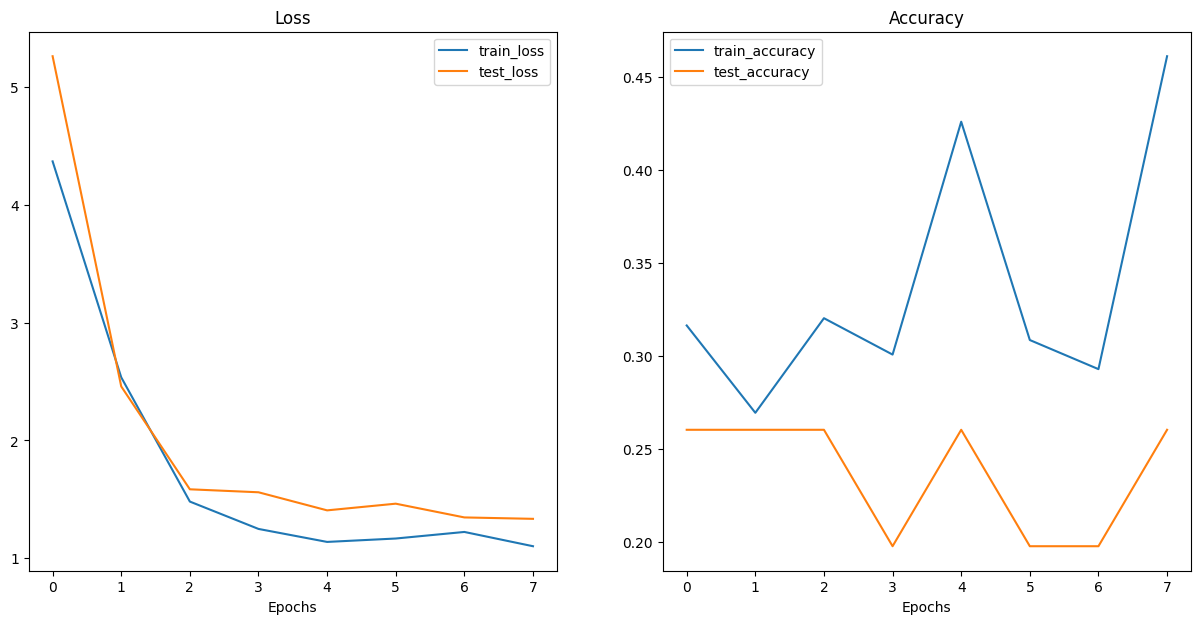

In [37]:
helper_funcs.plot_loss_curves(results)

### 9. Considering our Shabby Results
Our results aren't good. As evidenced by our high loss curves and wacky accuracy curves, we are underfitting.

The ViT paper uses a couple regularization techniques to prevent overfitting such as learning rate warmup, learning rate decay, and gradient clipping, which we forewent. These techniques make sense given their amount of data, but implementing these ourselves won't solve our problem.

Unlike traditional CNNs and ResNets, Transformers lack an inductive bias that causes them to perform pretty bad with less data.

Number one reason for our underfitting is scale, we simply don't have enough data to train on: the paper uses 1.3M (ImageNet-1k), 14M (ImageNet-21k), 303M (JFT) images compared to our measly 225. And their batch size is 4096 compared to our 32. It took their ViT model 30 days to train with 8 TPUv3 cores. At 8 bucks / hr that's $5760.

Nevertheless, there is a quick fix to get around our lack of data that will prevent both my macbook and my wallet from imploding: Transfer Learning.
* We will finetune a ViT model pretrained on a larger dataset to take advantage of their learned parameters

Definitions:
* Learning Rate Warmup - start with low learning rate and increase to a base lr
* Learning Rate Decay - as your model gets closer to convergence, start to lower the learning rate
* Gradient Clipping - prevent gradients from gettig too big


## 10. Pretrained ViT from torchvision.models

### 10.1 Finetuning a Feature Extractor from a Pretrained ViT

In [38]:
# pretrained weights for ViT-base
pretrained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# vit model instance w pretrained weights
vit_pretrained = torchvision.models.vit_b_16(weights=pretrained_weights).to(device)

# freeze base parameters
for parameter in vit_pretrained.parameters():
  parameter.requires_grad = False

# change classifier head for our 3 class names
helper_funcs.set_seeds()
vit_pretrained.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 153MB/s]


In [39]:
summary(model=vit_pretrained,
        input_size=(32, 3, 224, 224), # batch_size, color_channels, height, width
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### 10.2 Data Prep

In [40]:
# transforms from pretrained weights
vit_transforms = pretrained_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [41]:
# dataloaders
pretrained_train_dataloader, pretrained_test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32)

### 10.3 Train Feature Extractor ViT model

In [42]:
# optimizer and loss func
pretrained_optimizer = torch.optim.Adam(params=vit_pretrained.parameters(),
                                        lr=3e-3,
                                        betas=(0.9, 0.999),
                                        weight_decay=0.3)

loss_fn = torch.nn.CrossEntropyLoss()

# train the classifier head of pretrained ViT
helper_funcs.set_seeds()
pretrained_results = training_funcs.train(model=vit_pretrained,
                                          train_dataloader=pretrained_train_dataloader,
                                          test_dataloader=pretrained_test_dataloader,
                                          optimizer=pretrained_optimizer,
                                          loss_fn=loss_fn,
                                          epochs=10,
                                          device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7301 | train_acc: 0.7266 | test_loss: 0.5988 | test_acc: 0.7121
Epoch: 2 | train_loss: 0.4676 | train_acc: 0.7070 | test_loss: 0.4887 | test_acc: 0.7936
Epoch: 3 | train_loss: 0.4652 | train_acc: 0.7656 | test_loss: 0.6316 | test_acc: 0.6411
Epoch: 4 | train_loss: 0.3288 | train_acc: 0.8906 | test_loss: 0.6119 | test_acc: 0.6818
Epoch: 5 | train_loss: 0.2628 | train_acc: 0.9180 | test_loss: 0.5140 | test_acc: 0.7737
Epoch: 6 | train_loss: 0.2532 | train_acc: 0.9219 | test_loss: 0.4627 | test_acc: 0.7831
Epoch: 7 | train_loss: 0.2537 | train_acc: 0.9297 | test_loss: 0.4815 | test_acc: 0.8040
Epoch: 8 | train_loss: 0.2609 | train_acc: 0.9336 | test_loss: 0.5347 | test_acc: 0.7320
Epoch: 9 | train_loss: 0.2953 | train_acc: 0.9453 | test_loss: 0.5594 | test_acc: 0.7936
Epoch: 10 | train_loss: 0.2387 | train_acc: 0.9180 | test_loss: 0.5114 | test_acc: 0.7623


Nice! We imporved our highest test accuracy from 26% to 80% using pretrained weights. That's an improvement of 54%!

### 10.4 Plot Loss Curves
These loss and accuracy curves look much better

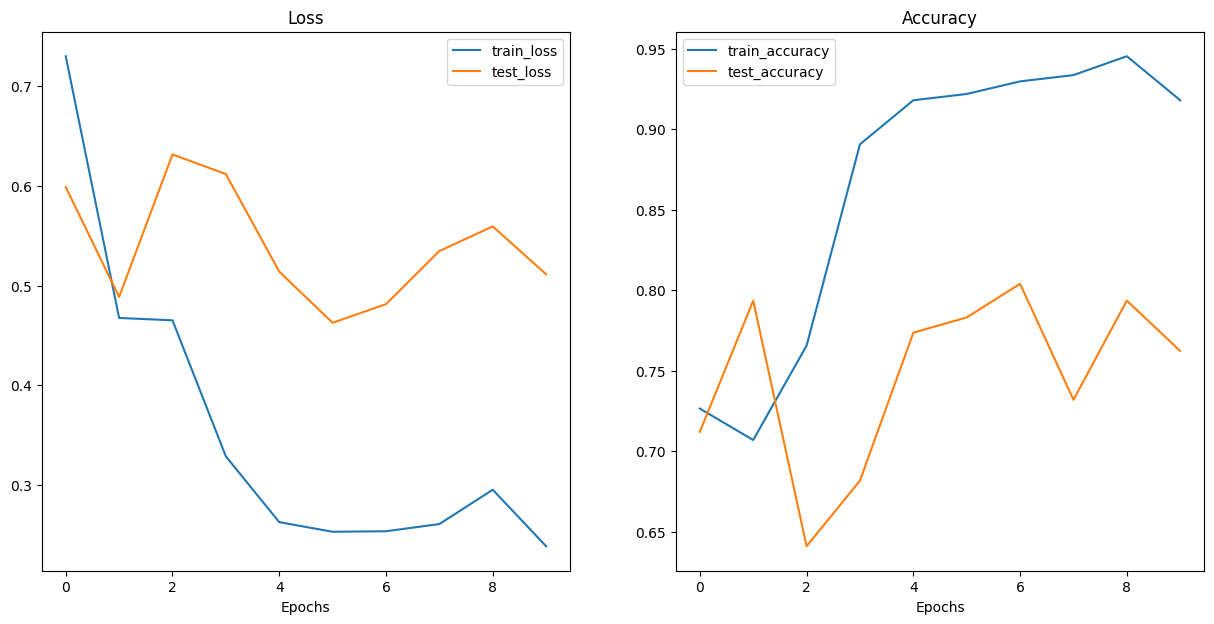

In [43]:
helper_funcs.plot_loss_curves(pretrained_results)

### 10.5 Save the Best Performing ViT Model

In [45]:
# from helper_funcs import save_model

helper_funcs.save_model(model=vit_pretrained,
                        target_dir='models',
                        model_name='pretrained_vit_feature_extractor.pth')

[INFO] Saving model to: models/pretrained_vit_feature_extractor.pth


In [46]:
# from pathlib import Path
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


We can evaluate the viability of our model size based on our deplloyment goal. If we are deploying as a mobile app, is our model too big?

## 11. Predicting on a Custom Image

data/three_foods/bbribs.jpeg already exists, skipping download.


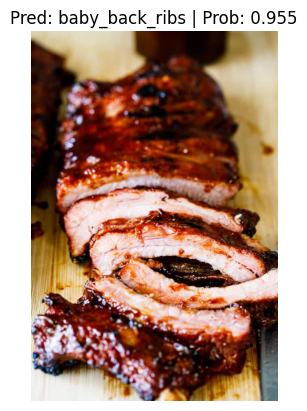

In [49]:
# import requests
from modules.pred_image import pred_and_plot_img

# Setup custom image path
custom_image_path = image_path / "bbribs.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/walker-at/Replicating-the-An-Image-is-Worth-16x16-Words-Paper/main/bbribs.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_img(model=vit_pretrained,
                  image_path=custom_image_path,
                  class_names=class_names)